In [1]:
import pandas as pd
import numpy as np
import cv2
import tifffile as tif
import matplotlib.pyplot as plt

import os, gc, glob
import json 

from shapely import wkt

import utils
import global_vars

In [2]:
im_names = sorted(glob.glob(os.path.join(global_vars.DATA_DIR, 'sixteen_band','*M.tif')))

In [3]:
grids = [x.split('/')[-1].split('_')[0] for x in im_names] 
grids = sorted(list(set((grids))))

In [4]:
def load_grid(paths):
    for j in range(5):
        for i in range(5):
            if i == 0:
                im = tif.imread(paths[j*5+i]).transpose((1,2,0))[:,:,[4,2,1]]
            else:
                tmp_im = tif.imread(paths[j*5+i]).transpose((1,2,0))[:,:,[4,2,1]]
                im = np.concatenate((im, tmp_im), axis=1)
        if j == 0:
            final_im = im
        else:
            final_im = np.concatenate((final_im, im))
            
    return cv2.resize(final_im,(500,500), interpolation=2)


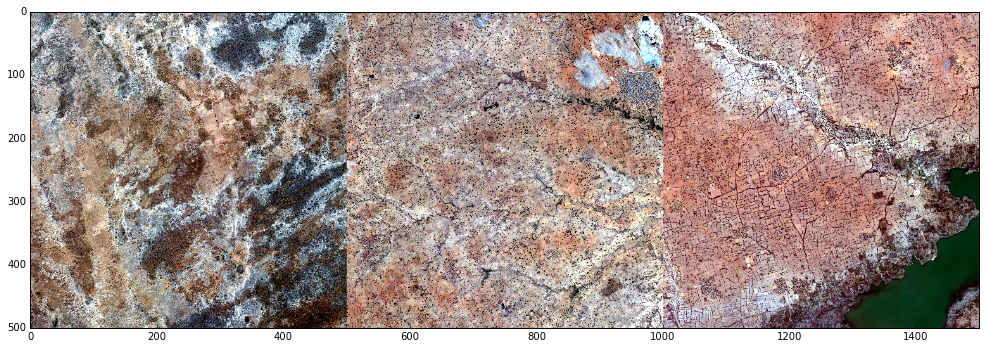

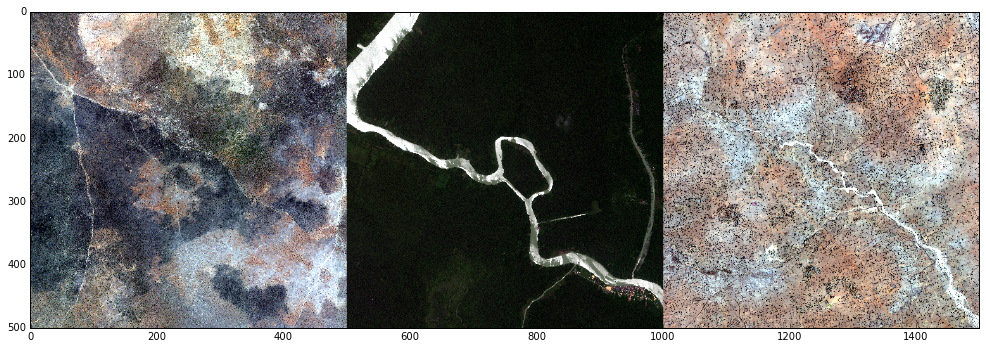

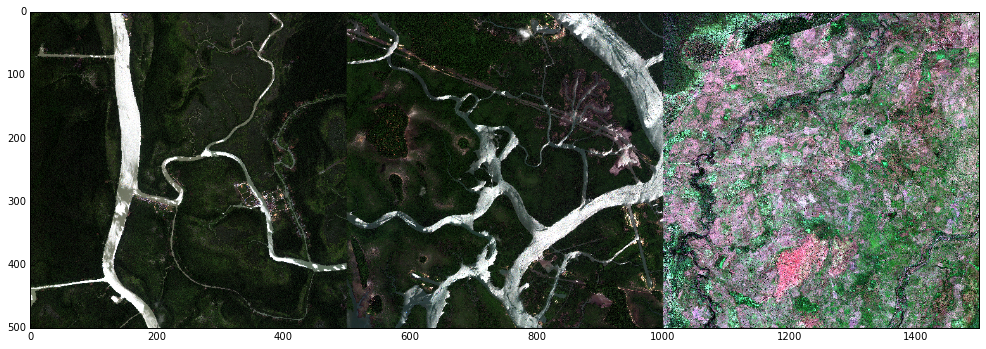

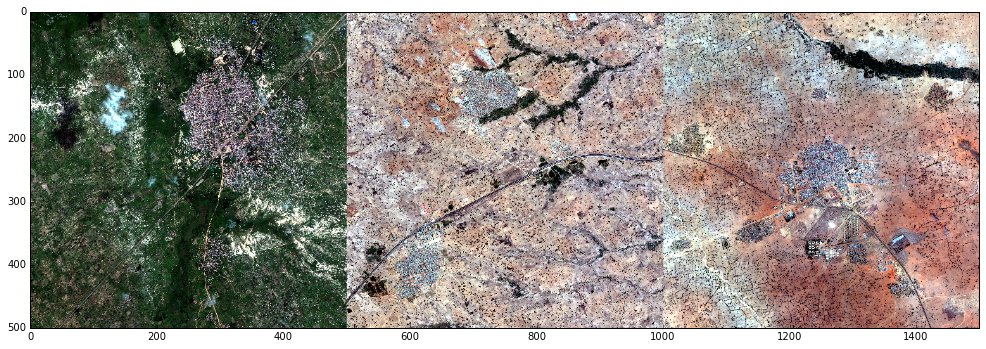

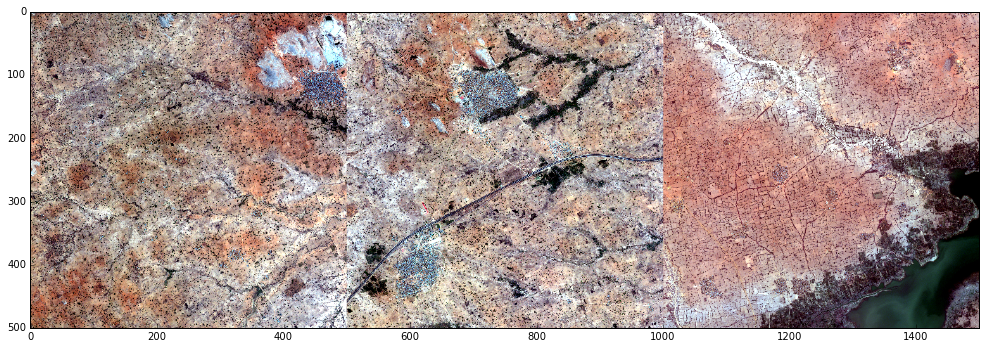

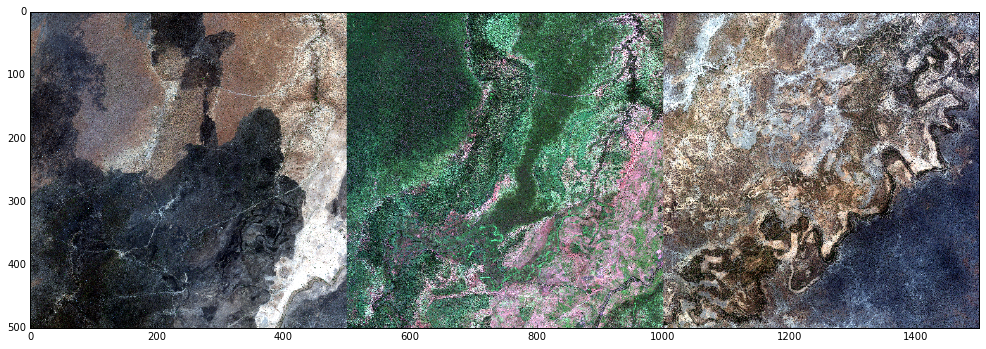

In [5]:
for j in range(6):
    for i in range(3):
        grid = grids[j*3+i]
        tmp = list(filter(lambda x: x.find(grid) != -1, im_names))
        if i == 0:
            big_im = utils.scl_prc(load_grid(tmp))
        else:
            tmp_grid = utils.scl_prc(load_grid(tmp))
            big_im = np.concatenate((big_im, tmp_grid), axis= 1)
    utils.shw(big_im, 7, 17)

            

The above shows all the images from the entire provided dataset. Immedietly we see that there are only 18 large images from which all the other images are taken from

Another thing to notice is that not all classes appear to be present in all patches. This fact can be used reduce the number of pixels at prediction time, and reduce false positive rate.

Now lets look at the counts of the various labels aggregated by grid 

In [6]:
#Get the train file names, 
train_wkt = pd.read_csv(os.path.join(global_vars.DATA_DIR,'train_wkt_v4.csv'))
train_wkt['area'] = 0

In [7]:
for i in range(train_wkt.shape[0]):
    if train_wkt.iloc[i,2] == 'MULTIPOLYGON EMPTY':
        continue
    else:
        train_wkt.iloc[i,3] = wkt.loads(train_wkt.iloc[i,2]).area * 10**11 #to make the numbers easier to reason about

In [8]:
train_wkt['grid'] = train_wkt['ImageId'].apply(lambda x: x.split('_')[0])

In [9]:
grid_class_areas = train_wkt.groupby(['grid', 'ClassType'])['area'].sum().unstack().astype(np.int)

In [10]:
grid_class_areas.T

grid          6010     6040     6060     6070     6090     6100      6110  \
ClassType                                                                   
1                0        0    11543   126625        0  1670426   1665838   
2             5416        0    25238    25096     2844   410765    389040   
3                0        0        0    66354        0   382269    488519   
4           272257   371957   251839        0    33749  2117960    813647   
5          3297467  4008842   702424  1308666   837989  1767983   1199802   
6                0   303266  7775792        0  2340603  3893772  15604768   
7                0        0        0   867268        0   155921         0   
8                0        0        0     4425    25941    65882    176389   
9                0        0        0        0        0     2967      2629   
10               0        0       26      475       66    11278      2770   

grid          6120     6140     6150    6160     6170  
ClassType                                              
1          1866211  1503024        0       0        0  
2           229765   322104    50324       0      224  
3           424294   313412        0       0        0  
4          1085055   552769   250953  231959   235240  
5           836895   745417  1123483  851317  4382131  
6          7470139  8873067  6703740       0  4100749  
7                0        0        0       0        0  
8            23759    50417        0       0     1991  
9             1773      348        0       0        0  
10           13305     3678        0       0        0